In [11]:
import pandas as pd
import numpy as np

#Plotting liibs
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


#Football libs
import socceraction
from socceraction.data.statsbomb import StatsBombLoader
from mplsoccer import Pitch, Sbopen, VerticalPitch
import socceraction.spadl as spadl
import matplotsoccer as mps
import socceraction.xthreat as xthreat
import socceraction.spadl as spadl
from socceraction.vaep import VAEP

# utils
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
# fuzz is used to compare TWO strings
from fuzzywuzzy import fuzz
# process is used to compare a string to MULTIPLE other strings
from fuzzywuzzy import process

# ML libs
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler,  MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA



## Clustering players

In [77]:
clustering_df = df_actions_zones.groupby(['player_id','start_pitch_zone'])['start_x','start_y'].mean().reset_index()

clustering_df['frequency'] = df_actions_zones.groupby(['player_id', 'start_pitch_zone'])[['start_pitch_zone']].value_counts().values

In [78]:
clustering_df.head()

,player_id,start_pitch_zone,start_x,start_y,frequency
0,4633.0,zone_1,22.525882,16.078987,75
1,4633.0,zone_2,22.263363,38.728213,635
2,4633.0,zone_3,22.498169,54.164551,1349
3,4633.0,zone_4,48.187500,17.367018,72
4,4633.0,zone_5,47.773566,38.150974,717


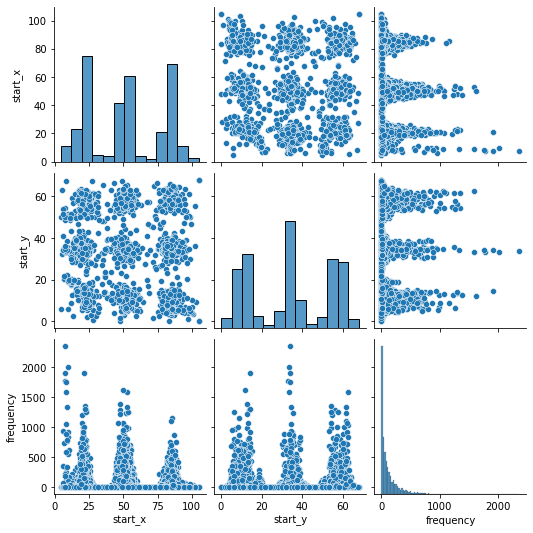

In [79]:
sns.pairplot(clustering_df[['start_pitch_zone', 'start_x', 'start_y','frequency']])
plt.show()

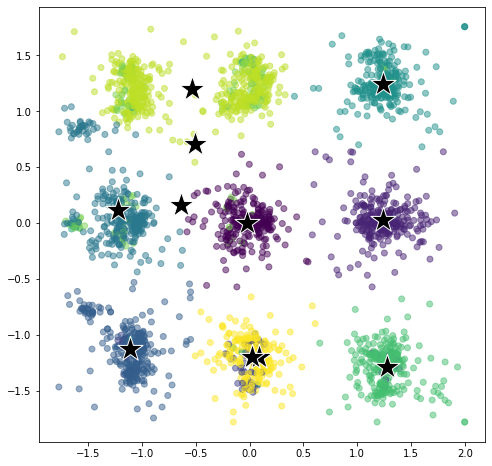

In [80]:
X = clustering_df[['start_x','start_y', 'frequency']]

ss = StandardScaler()
X = ss.fit_transform(X)

# Instantiate
k_means_model_2= KMeans(n_clusters=11)

# Fit
k_means_model_2.fit(X)
cluster_labels = k_means_model_2.predict(X)
centers = k_means_model_2.cluster_centers_

plt.figure(figsize=(8, 8))
plt.scatter(X[:,0], X[:,1], c=cluster_labels, alpha=0.5)
plt.scatter(centers[:, 0], centers[:, 1], 
            c='black', marker="*", edgecolor="white", s=700)
plt.show()

In [81]:
clustering_df['cluster_labels'] = cluster_labels

In [82]:
# We will explore different values for k, and look at the scree plot ('elbow method') 
# using inertia. We will also look at the silhouette score

ks = np.arange(2, 99)
inertia_list = []
silhouette_score_list = []

for k in ks:

    # Instantiate
    my_kmeans = KMeans(n_clusters=k)
    
    # Fit (i.e. get clusters)
    y_labels = my_kmeans.fit_predict(X)
    
    # Append inertia
    inertia_list.append(my_kmeans.inertia_)

    # Append silhouette
    silhouette = silhouette_score(X, y_labels)
    silhouette_score_list.append(silhouette)

In [83]:
np.argmax(silhouette_score_list)
np.arange(2,88)[13]

15

In [84]:
# inertias = pd.Series(inertia_list)
# abs(inertias.pct_change().sort_values(ascending=True))

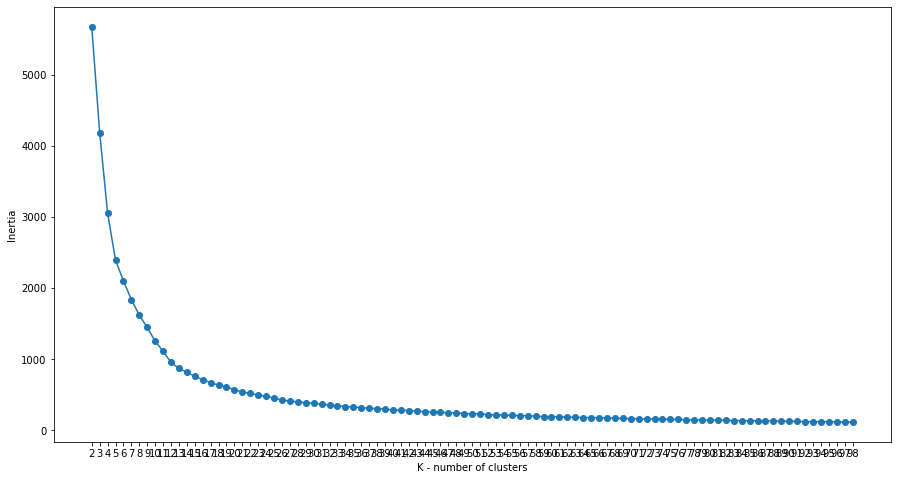

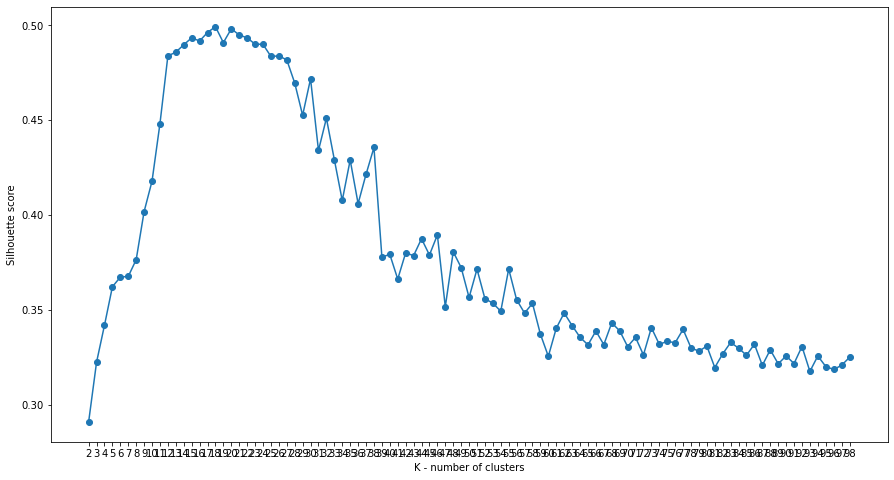

In [85]:
plt.figure(figsize=(15,8))

plt.plot(ks, inertia_list, marker='o')
plt.xlabel('K - number of clusters')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

plt.figure(figsize=(15,8))

plt.plot(ks, silhouette_score_list, marker='o')
plt.xlabel('K - number of clusters')
plt.ylabel('Silhouette score')
plt.xticks(ks)

plt.show()

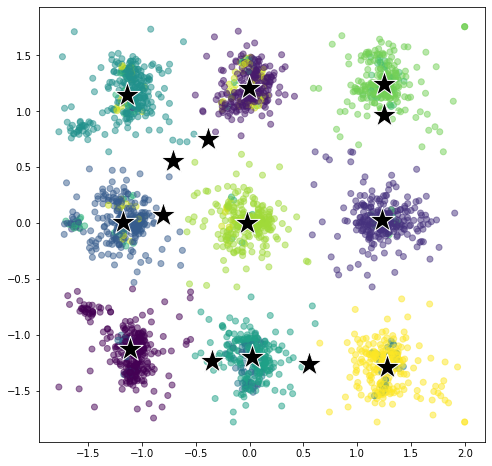

In [86]:
# Instantiate
k_means_model_2= KMeans(n_clusters=15)

# Fit
k_means_model_2.fit(X)
cluster_labels = k_means_model_2.predict(X)
centers = k_means_model_2.cluster_centers_

plt.figure(figsize=(8, 8))
plt.scatter(X[:,0], X[:,1], c=cluster_labels, alpha=0.5)
plt.scatter(centers[:, 0], centers[:, 1], 
            c='black', marker="*", edgecolor="white", s=700)
plt.show()

In [87]:
X_with_labels = pd.DataFrame(X)
X_with_labels['labels'] = cluster_labels

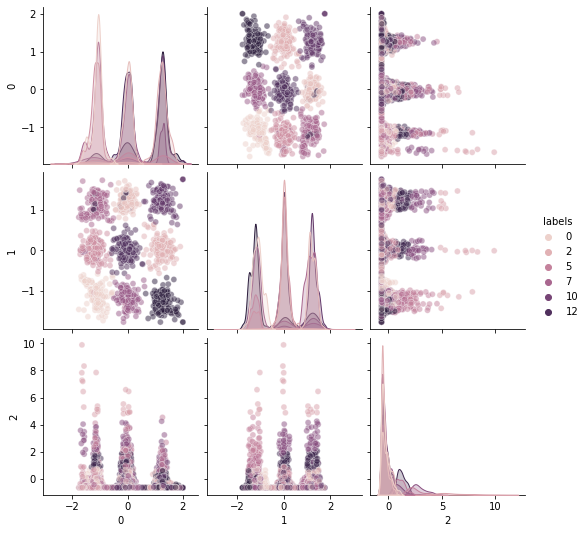

In [88]:
sns.pairplot(X_with_labels, hue='labels', plot_kws={'alpha': 0.5})
plt.show()

In [89]:
silhouette_scores = []
num_clusters = []
epsilons = np.arange(0.1, 1.2, 0.1)

for eps in epsilons:

    # Instantiate
    model = DBSCAN(eps=eps, min_samples=5)

    # Fit
    y_labels = model.fit_predict(X)
    
    # we disregard the noise label -1
    n_clusters = len(np.unique(y_labels[y_labels != -1]))
    print(f'eps = {eps} --- n_clusters: {n_clusters}')
    
    silhouette = silhouette_score(X, y_labels)
    silhouette_scores.append(silhouette)
    num_clusters.append(n_clusters)

eps = 0.1 --- n_clusters: 54
eps = 0.2 --- n_clusters: 19
eps = 0.30000000000000004 --- n_clusters: 4
eps = 0.4 --- n_clusters: 5
eps = 0.5 --- n_clusters: 3
eps = 0.6 --- n_clusters: 1
eps = 0.7000000000000001 --- n_clusters: 1
eps = 0.8 --- n_clusters: 1
eps = 0.9 --- n_clusters: 1
eps = 1.0 --- n_clusters: 1
eps = 1.1 --- n_clusters: 2


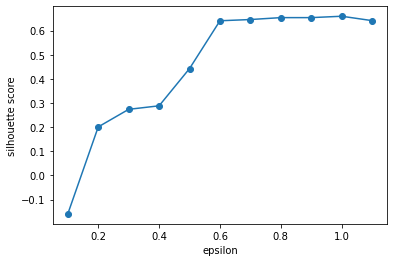

In [90]:
plt.figure()
plt.plot(epsilons, 
         silhouette_scores, 
         marker='o')
plt.xlabel('epsilon')
plt.ylabel('silhouette score')
plt.show()

## Feature Selection, Encoding and Pre-processing 

- Check class balances 
- Deal with imbalances 
- Encode categorical columns - we can do column transformations as part of GridSearch
- Split into Test and Train
- Scale Data


### TO DO: 

Person correlations for: 
- end_pitch_zone
- action_type
- xT
- VAEP

Need to one hot encode the categories

In [91]:
# from scipy import stats
# data = []
# num_col = df_actions_zones.select_dtypes(include=[np.number])

# for column in num_col.corr().columns:
#     data.append(stats.pearsonr(df_actions_zones['end_pitch_zone'], df_actions_zones[column]))

# end_zone_corr = pd.DataFrame(data, index=df_actions_zones.corr().columns, columns=['Correlation', 'P_value'])

# end_zone_corr.style.background_gradient(cmap='Oranges')

In [92]:
# from scipy import stats 
# data = []
# for column in corr:
#     data.append(stats.pearsonr(df_actions_zones['end_x'], df_actions_zones[column]))

# num_col_corr = pd.DataFrame(data, index=corr.columns, columns=['Correlation', 'P_value'])
# num_col_corr.style.background_gradient(cmap='Oranges')

In [93]:
modeling_train_df = df_actions_zones.copy()
modeling_test_df = df_actions_zones_test.copy()

## Player approach

In [94]:
players.groupby('player_id')['minutes_played'].sum().sort_values(ascending=False).head()

player_id
10185    3450
15709    3278
4633     3260
4658     3257
16376    3242
Name: minutes_played, dtype: int64

In [95]:
player_id = 4658

In [96]:
player_train_set = modeling_train_df[
    (modeling_train_df['player_id']==player_id)
    & (modeling_train_df['n-5_same_player']!=True)
    & (modeling_train_df['n-4_same_player']!=True)
    & (modeling_train_df['n-3_same_player']!=True)
    & (modeling_train_df['n-2_same_player']!=True)
    & (modeling_train_df['n-1_same_player']!=True)
    ]
player_train_set.shape

(2021, 122)

In [97]:
player_test_set = modeling_test_df[
    (modeling_test_df['player_id']==player_id)
    & (modeling_test_df['n-5_same_player']!=True)
    & (modeling_test_df['n-4_same_player']!=True)
    & (modeling_test_df['n-3_same_player']!=True)
    & (modeling_test_df['n-2_same_player']!=True)
    & (modeling_test_df['n-1_same_player']!=True)
    ]
player_test_set.shape

(1230, 122)

In [98]:
player_train_set.dropna(inplace=True)
player_train_set.shape

(1941, 122)

In [99]:
player_test_set.dropna(inplace=True)
player_test_set.shape

(1178, 122)

In [100]:
X_train = player_train_set.drop(columns=['type_name_encoded', 'end_pitch_zone'])
y_train_type = player_train_set['type_name_encoded']
y_train_end_zone = player_train_set['end_pitch_zone']

X_test = player_test_set.drop(columns=['type_name_encoded', 'end_pitch_zone'])
y_test_type = player_test_set['type_name_encoded']
y_test_end_zone = player_test_set['end_pitch_zone']

In [101]:
X_test.head()

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,offensive_value,defensive_value,vaep_value,start_pitch_zone,opponent_id,home,x_dif,y_dif,n-1_x_distance,n-1_y_distance,n-1_same_team,n-1_same_player,n-1_x_fwd_direction,n-1_y_lft_right_direction,n-1_start_pitch_zone,n-1_end_pitch_zone,n-1_start_x,n-1_start_y,n-1_end_x,n-1_end_y,n-1_type_name,n-1_type_name_encoded,n-1_result_name,n-1_bodypart_name,n-1_offensive_value,n-1_defensive_value,n-1_vaep_value,n-2_x_distance,n-2_y_distance,n-2_same_team,n-2_same_player,n-2_x_fwd_direction,n-2_y_lft_right_direction,n-2_start_pitch_zone,n-2_end_pitch_zone,n-2_start_x,n-2_start_y,n-2_end_x,n-2_end_y,n-2_type_name,n-2_type_name_encoded,n-2_result_name,n-2_bodypart_name,n-2_offensive_value,n-2_defensive_value,n-2_vaep_value,n-3_x_distance,n-3_y_distance,n-3_same_team,n-3_same_player,n-3_x_fwd_direction,n-3_y_lft_right_direction,n-3_start_pitch_zone,n-3_end_pitch_zone,n-3_start_x,n-3_start_y,n-3_end_x,n-3_end_y,n-3_type_name,n-3_type_name_encoded,n-3_result_name,n-3_bodypart_name,n-3_offensive_value,n-3_defensive_value,n-3_vaep_value,n-4_x_distance,n-4_y_distance,n-4_same_team,n-4_same_player,n-4_x_fwd_direction,n-4_y_lft_right_direction,n-4_start_pitch_zone,n-4_end_pitch_zone,n-4_start_x,n-4_start_y,n-4_end_x,n-4_end_y,n-4_type_name,n-4_type_name_encoded,n-4_result_name,n-4_bodypart_name,n-4_offensive_value,n-4_defensive_value,n-4_vaep_value,n-5_x_distance,n-5_y_distance,n-5_same_team,n-5_same_player,n-5_x_fwd_direction,n-5_y_lft_right_direction,n-5_start_pitch_zone,n-5_end_pitch_zone,n-5_start_x,n-5_start_y,n-5_end_x,n-5_end_y,n-5_type_name,n-5_type_name_encoded,n-5_result_name,n-5_bodypart_name,n-5_offensive_value,n-5_defensive_value,n-5_vaep_value
44,3775624,629b02f1-e29f-438b-b169-4dcf2d39a0e4,1,72.0,746,4658.0,28.588235,9.726582,28.588235,9.726582,21,1,0,44,dribble,success,foot,-0.000356,-0.000479,-0.000835,zone_1,1475,0,0.000000,0.000000,13.676471,4.303797,True,False,1,1,zone_1,zone_1,14.911765,5.422785,28.588235,9.726582,pass,pass,success,foot,0.000345,0.003414,0.003759,5.470588,-5.939241,True,False,1,0,zone_1,zone_1,9.441176,11.362025,14.911765,5.422785,dribble,dribble,success,foot,0.000184,-0.002553,-0.002369,-4.500000,-14.202532,True,False,0,0,zone_2,zone_1,13.941176,25.564557,9.441176,11.362025,pass,pass,success,foot,-0.000029,-0.000589,-0.000618,0.000000,0.000000,True,False,0,0,zone_2,zone_2,13.941176,25.564557,13.941176,25.564557,dribble,dribble,success,foot,-0.000085,0.000295,0.000210,10.941176,-2.754430,True,False,1,0,zone_2,zone_2,3.000000,28.318987,13.941176,25.564557,pass,pass,success,foot,-0.000057,0.001316,0.001259
95,3775624,d737ddc1-2cee-46d2-b684-8f90d3c912d8,1,189.0,746,4658.0,60.882353,40.197468,63.617647,27.113924,21,1,0,95,dribble,success,foot,0.002056,-0.000974,0.001082,zone_5,1475,0,2.735294,-13.083544,-4.588235,-7.918987,True,False,0,0,zone_6,zone_5,65.470588,48.116456,60.882353,40.197468,pass,pass,success,foot,-0.005519,0.000103,-0.005415,2.294118,-11.275949,True,False,1,0,zone_6,zone_6,63.176471,59.392405,65.470588,48.116456,dribble,dribble,success,foot,0.005063,-0.000014,0.005049,8.029412,28.749367,True,False,1,1,zone_5,zone_6,55.147059,30.643038,63.176471,59.392405,pass,pass,success,foot,0.003436,0.000773,0.004209,6.264706,2.754430,True,False,1,1,zone_5,zone_5,48.882353,27.888608,55.147059,30.643038,dribble,dribble,success,foot,-0.006358,0.001888,-0.004471,-4.676471,-21.174684,False,False,0,0,zone_6,zone_5,60.000000,62.060759,55.323529,40.886076,pass,pass,fail,foot,0.001792,-0.008668,-0.006876
219,3775624,20388b02-e6bc-470f-aa4a-c480865c43bc,1,546.0,746,4658.0,74.647059,13.255696,74.294118,11.706329,21,1,0,219,dribble,success,foot,0.000813,-0.000144,0.000669,zone_7,1475,0,-0.352941,-1.549367,-2.911765,9.554430,True,False,0,1,zone_7,zone_7,77.558824,3.701266,74.647059,13.255696,pass,pass,success,foot,0.002612,0.000023,0.002635,-1.058824,0.5

In [102]:
numeric_features = [
    'start_x',
    'start_y',
    'time_seconds',
    'n-1_x_distance',
    'n-1_y_distance',
    'n-1_start_x',
    'n-1_start_y',
    'n-1_end_x',
    'n-1_end_y',
    'n-1_offensive_value',
    'n-1_defensive_value',
    'n-1_vaep_value',
    'n-2_x_distance',
    'n-2_y_distance',
    'n-2_start_x',
    'n-2_start_y',
    'n-2_end_x',
    'n-2_end_y',
    'n-2_offensive_value',
    'n-2_defensive_value',
    'n-2_vaep_value',
    'n-3_x_distance',
    'n-3_y_distance',
    'n-3_start_x',
    'n-3_start_y',
    'n-3_end_x',
    'n-3_end_y',
    'n-3_offensive_value',
    'n-3_defensive_value',
    'n-3_vaep_value',
    'n-4_x_distance',
    'n-4_y_distance',
    'n-4_start_x',
    'n-4_start_y',
    'n-4_end_x',
    'n-4_end_y',
    'n-4_offensive_value',
    'n-4_defensive_value',
    'n-4_vaep_value',
    'n-5_x_distance',
    'n-5_y_distance',
    'n-5_start_x',
    'n-5_start_y',
    'n-5_end_x',
    'n-5_end_y',
    'n-5_offensive_value',
    'n-5_defensive_value',
    'n-5_vaep_value',
    ]

categorical_features = [
    'period_id',
    'start_pitch_zone',
    'opponent_id',
    'home',
    'n-1_same_team',
    'n-1_x_fwd_direction',
    'n-1_y_lft_right_direction',
    'n-1_start_pitch_zone',
    'n-1_end_pitch_zone',
    'n-1_type_name_encoded',
    'n-1_result_name',
    'n-1_bodypart_name',
    'n-2_same_team',
    'n-2_x_fwd_direction',
    'n-2_y_lft_right_direction',
    'n-2_start_pitch_zone',
    'n-2_end_pitch_zone',
    'n-2_type_name_encoded',
    'n-2_result_name',
    'n-2_bodypart_name',
    'n-3_same_team',
    'n-3_x_fwd_direction',
    'n-3_y_lft_right_direction',
    'n-3_start_pitch_zone',
    'n-3_end_pitch_zone',
    'n-3_type_name_encoded',
    'n-3_result_name',
    'n-3_bodypart_name',
    'n-4_same_team',
    'n-4_x_fwd_direction',
    'n-4_y_lft_right_direction',
    'n-4_start_pitch_zone',
    'n-4_end_pitch_zone',
    'n-4_type_name_encoded',
    'n-4_result_name',
    'n-4_bodypart_name',
    'n-5_same_team',
    'n-5_x_fwd_direction',
    'n-5_y_lft_right_direction',
    'n-5_start_pitch_zone',
    'n-5_end_pitch_zone',
    'n-5_type_name_encoded',
    'n-5_result_name',
    'n-5_bodypart_name',
    ]

# some of the features below will need dropping before training the model - but are required here for filtering dataset
# passthrough_features = [
#     'game_id',
#     'player_id',
#     ]

drop_features = [
    'original_event_id',
    'game_id',
    'player_id',
    'team_id',
    'end_x',
    'end_y',
    'type_id',
    'result_id',
    'bodypart_id',
    'action_id',
    'type_name',
    'result_name',
    'bodypart_name',
    'offensive_value',
    'defensive_value',
    'vaep_value',
    'x_dif',
    'y_dif',
    'n-1_same_player',
    'n-2_same_player',
    'n-3_same_player',
    'n-4_same_player',
    'n-5_same_player',
    ]

In [103]:
ct = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    # ('passthrough', passthrough_features),
    ('drop', drop_features))

In [104]:
transformed_train_df = ct.fit_transform(X_train)
column_names = (
    numeric_features 
    # + passthrough_features
    + ct.named_transformers_['onehotencoder'].get_feature_names_out().tolist())
    
transformed_train_df = pd.DataFrame(transformed_train_df, columns=column_names)
transformed_train_df.head(20)

,start_x,start_y,time_seconds,n-1_x_distance,n-1_y_distance,n-1_start_x,n-1_start_y,n-1_end_x,n-1_end_y,n-1_offensive_value,n-1_defensive_value,n-1_vaep_value,n-2_x_distance,n-2_y_distance,n-2_start_x,n-2_start_y,n-2_end_x,n-2_end_y,n-2_offensive_value,n-2_defensive_value,n-2_vaep_value,n-3_x_distance,n-3_y_distance,n-3_start_x,n-3_start_y,n-3_end_x,n-3_end_y,n-3_offensive_value,n-3_defensive_value,n-3_vaep_value,n-4_x_distance,n-4_y_distance,n-4_start_x,n-4_start_y,n-4_end_x,n-4_end_y,n-4_offensive_value,n-4_defensive_value,n-4_vaep_value,n-5_x_distance,n-5_y_distance,n-5_start_x,n-5_start_y,n-5_end_x,n-5_end_y,n-5_offensive_value,n-5_defensive_value,n-5_vaep_value,period_id_1,period_id_2,start_pitch_zone_zone_1,start_pitch_zone_zone_2,start_pitch_zone_zone_3,start_pitch_zone_zone_4,start_pitch_zone_zone_5,start_pitch_zone_zone_6,start_pitch_zone_zone_7,start_pitch_zone_zone_8,start_pitch_zone_zone_9,opponent_id_749,opponent_id_965,opponent_id_966,opponent_id_967,opponent_id_968,opponent_id_969,opponent_id_970,opponent_id_971,opponent_id_972,opponent_id_973,opponent_id_974,opponent_id_1475,home_0,home_1,n-1_same_team_False,n-1_same_team_True,n-1_x_fwd_direction_0,n-1_x_fwd_direction_1,n-1_y_lft_right_direction_0,n-1_y_lft_right_direction_1,n-1_start_pitch_zone_zone_1,n-1_start_pitch_zone_zone_2,n-1_start_pitch_zone_zone_3,n-1_start_pitch_zone_zone_4,n-1_start_pitch_zone_zone_5,n-1_start_pitch_zone_zone_6,n-1_start_pitch_zone_zone_7,n-1_start_pitch_zone_zone_8,n-1_start_pitch_zone_zone_9,n-1_end_pitch_zone_zone_1,n-1_end_pitch_zone_zone_2,n-1_end_pitch_zone_zone_3,n-1_end_pitch_zone_zone_4,n-1_end_pitch_zone_zone_5,n-1_end_pitch_zone_zone_6,n-1_end_pitch_zone_zone_7,n-1_end_pitch_zone_zone_8,n-1_end_pitch_zone_zone_9,n-1_type_name_encoded_dribble,n-1_type_name_encoded_other,n-1_type_name_encoded_pass,n-1_result_name_fail,n-1_result_name_offside,n-1_result_name_success,n-1_result_name_yellow_card,n-1_bodypart_name_foot,n-1_bodypart_name_head,n-1_bodypart_name_other,n-2_same_team_False,n-2_same_team_True,n-2_x_fwd_direction_0,n-2_x_fwd_direction_1,n-2_y_lft_right_direction_0,n-2_y_lft_right_direction_1,n-2_start_pitch_zone_zone_1,n-2_start_pitch_zone_zone_2,n-2_start_pitch_zone_zone_3,n-2_start_pitch_zone_zone_4,n-2_start_pitch_zone_zone_5,n-2_start_pitch_zone_zone_6,n-2_start_pitch_zone_zone_7,n-2_start_pitch_zone_zone_8,n-2_start_pitch_zone_zone_9,n-2_end_pitch_zone_zone_1,n-2_end_pitch_zone_zone_2,n-2_end_pitch_zone_zone_3,n-2_end_pitch_zone_zone_4,n-2_end_pitch_zone_zone_5,n-2_end_pitch_zone_zone_6,n-2_end_pitch_zone_zone_7,n-2_end_pitch_zone_zone_8,n-2_end_pitch_zone_zone_9,n-2_type_name_encoded_dribble,n-2_type_name_encoded_other,n-2_type_name_encoded_pass,n-2_result_name_fail,n-2_result_name_offside,n-2_result_name_owngoal,n-2_result_name_success,n-2_result_name_yellow_card,n-2_bodypart_name_foot,n-2_bodypart_name_head,n-2_bodypart_name_other,n-3_same_team_False,n-3_same_team_True,n-3_x_fwd_direction_0,n-3_x_fwd_direction_1,n-3_y_lft_right_direction_0,n-3_y_lft_right_direction_1,n-3_start_pitch_zone_zone_1,n-3_start_pitch_zone_zone_2,n-3_start_pitch_zone_zone_3,n-3_start_pitch_zone_zone_4,n-3_start_pitch_zone_zone_5,n-3_start_pitch_zone_zone_6,n-3_start_pitch_zone_zone_7,n-3_start_pitch_zone_zone_8,n-3_start_pitch_zone_zone_9,n-3_end_pitch_zone_zone_1,n-3_end_pitch_zone_zone_2,n-3_end_pitch_zone_zone_3,n-3_end_pitch_zone_zone_4,n-3_end_pitch_zone_zone_5,n-3_end_pitch_zone_zone_6,n-3_end_pitch_zone_zone_7,n-3_end_pitch_zone_zone_8,n-3_end_pitch_zone_zone_9,n-3_type_name_encoded_dribble,n-3_type_name_encoded_other,n-3_type_name_encoded_pass,n-3_result_name_fail,n-3_result_name_offside,n-3_result_name_success,n-3_result_name_yellow_card,n-3_bodypart_name_foot,n-3_bodypart_name_head,n-3_bodypart_name_other,n-4_same_team_False,n-4_same_team_True,n-4_x_fwd_direction_0,n-4_x_fwd_direction_1,n-4_y_lft_right_direction_0,n-4_y_lft_right_direction_1,n-4_start_pitch_zone_zone_1,n-4_start_pitch_zone_zone_2,n-4_start_pitch_zone_zone_3,

## Baseline Model

In [105]:
pipe = make_pipeline(ct, LogisticRegression())
pipe.fit(X_train, y_train_type)
print(pipe.score(X_train, y_train_type))
print(pipe.score(X_test, y_test_type))

0.8665636269963937
0.7275042444821732


In [106]:
pipe_svm = make_pipeline(ct, svm.SVC())
pipe_svm.fit(X_train, y_train_type)
print(pipe_svm.score(X_train, y_train_type))
print(pipe_svm.score(X_test, y_test_type))

0.8758371973209685
0.7478777589134126


In [107]:
pipe = make_pipeline(ct, DecisionTreeClassifier())
pipe.fit(X_train, y_train_type)
print(pipe.score(X_train, y_train_type))
print(pipe.score(X_test, y_test_type))

1.0
0.6859083191850595


In [108]:
pipe = make_pipeline(ct, LogisticRegression())
pipe.fit(X_train, y_train_end_zone)
print(pipe.score(X_train, y_train_end_zone))
print(pipe.score(X_test, y_test_end_zone))

0.88768675940237
0.7096774193548387


In [109]:
pipe = make_pipeline(ct, svm.SVC())
pipe.fit(X_train, y_train_end_zone)
print(pipe.score(X_train, y_train_end_zone))
print(pipe.score(X_test, y_test_end_zone))

0.8608964451313755
0.7317487266553481


In [110]:
pipe = make_pipeline(ct, DecisionTreeClassifier())
pipe.fit(X_train, y_train_end_zone)
print(pipe.score(X_train, y_train_end_zone))
print(pipe.score(X_test, y_test_end_zone))

1.0
0.66723259762309


## Baseline - Team Approach

In [111]:
df_games['away_team_id'].unique()

array([ 971,  969,  970,  968,  974,  965,  973,  966,  967,  746,  972,
       1475,  749])

In [112]:
team_train_set = modeling_train_df[modeling_train_df['team_id']==1475].dropna()
team_test_set = modeling_test_df[modeling_test_df['team_id']==1475].dropna()

X_train = team_train_set.drop(columns=['type_name_encoded', 'end_pitch_zone'])
y_train_type = team_train_set['type_name_encoded']
y_train_end_zone = team_train_set['end_pitch_zone']

X_test = team_test_set.drop(columns=['type_name_encoded', 'end_pitch_zone'])
y_test_type = team_test_set['type_name_encoded']
y_test_end_zone = team_test_set['end_pitch_zone']

In [113]:
pipe = make_pipeline(ct, LogisticRegression())
pipe.fit(X_train, y_train_type)
print(pipe.score(X_train, y_train_type))
print(pipe.score(X_test, y_test_type))

0.7938449240607514
0.7760580742364059


In [114]:
pipe = make_pipeline(ct, svm.SVC())
pipe.fit(X_train, y_train_type)
print(pipe.score(X_train, y_train_type))
print(pipe.score(X_test, y_test_type))

0.8383693045563549
0.7853718668675523


In [115]:
pipe = make_pipeline(ct, DecisionTreeClassifier())
pipe.fit(X_train, y_train_type)
print(pipe.score(X_train, y_train_type))
print(pipe.score(X_test, y_test_type))

1.0
0.7320914943158472


In [116]:
pipe = make_pipeline(ct, DecisionTreeClassifier())
pipe.fit(X_train, y_train_end_zone)
print(pipe.score(X_train, y_train_end_zone))
print(pipe.score(X_test, y_test_end_zone))

1.0
0.5585079669451674


## Identifying transfers

In [117]:
transfer_players = ["Anna Patten","Carlotte Wubben-Moy","Lydia Williams","Noelle Maritz","Stephanie Catley","Fran Stenson","Mana Iwabuchi","Ramona Petzelberger","Anita Asante","Diana Silva","Freya Gregory","Stine Larsen","Caroline Siems","Lisa Weiß","Ruby Mace","Sophie Whitehouse","Veatriki Sarri","Ruesha Littlejohn","Emily Murphy","Jamie-Lee Napier","Rachel Corsie","Mollie Green","Chloe McCarron","Christie Murray","Emma Koivisto","Katie Startup","Rebekah Stott","Inessa Kaagman","Nora Heroum","Katie Robinson","Kiera Skeels","Molly Pike","Benedicte Håland","Emma Bissell","Aimee Palmer","Jemma Purfield","Laura Rafferty","Ella Rutherford","Zećira Mušović","Pernille Harder","Niamh Charles","Jessie Fleming","Melanie Leupolz","Alisha Lehmann","Jill Scott","Claire Emslie","Valérie Gauvin","Nicoline Sørensen","Damaris Egurrola","Poppy Pattinson","Rikke Sevecke","Ingrid Wold","Abby Dahlkemper","Alex Greenwood","Lucy Bronze","Samantha Mewis","Chloe Kelly","Esme Morgan","Emily Ramsey","Maria Thorisdottir","Fran Bentley","Alessia Russo","Ivana Fuso","Lucy Staniforth","Mollie Green","Carrie Jones","Ona Batlle","Danielle Carter","Deanna Cooper","Jessica Fishlock","Silvana Flores","Ga-Eul Jeon","Emma Mukandi","Erin Nayler","Lily Woodham","So-hyun Cho","Abbie McManus","Alanna Kennedy","Sophie Whitehouse","Alex Morgan","Shelina Zadorsky","Kerys Harrop","Aurora Mikalsen","Rachel Williams","Dagný Brynjarsdóttir","Anouk Denton","Jacynta Galabadaarachchi","Emily Ramsey","Lois Joel","Rachel Daly","Emily van Egmond","Hawa Cissoko","Kateřina Svitková","Mackenzie Arnold","Mia Cruickshank","Ruby Grant","Maz Pacheco"]


In [118]:
players[players['player_name'].isin(transfer_players)].groupby(['player_id','player_name'])['minutes_played'].sum().reset_index().sort_values(by='minutes_played',ascending=False).head(10)

,player_id,player_name,minutes_played
3,10172,Jill Scott,3125
14,18153,Alisha Lehmann,2852
4,15562,Lucy Staniforth,2584
7,15579,Inessa Kaagman,2516
13,17274,Poppy Pattinson,2350
5,15569,Kerys Harrop,2244
2,4648,Abbie McManus,2139
6,15570,Chloe Kelly,2113
9,15631,Niamh Charles,1642
11,16388,Ella Rutherford,1519


In [119]:
transfer_players_df = pd.DataFrame(transfer_players, columns=['player_name'])

In [120]:
list1 = transfer_players
list2 = players_test['player_name'].tolist()
threshold=70

# empty lists for storing the
# matches later
mat1 = []
mat2 = []

# iterating through list1 to extract 
# it's closest match from list2
for i in list1:
    mat1.append(process.extract(i, list2, limit=2))
transfer_players_df['matches'] = mat1

# iterating through the closest
# matches to filter out the
# maximum closest match

for j in transfer_players_df['matches']:
    
    for k in j:
        p = []
        if k[1] >= threshold:
            p.append(k[0])      
    mat2.append(",".join(p))
    
      
# storing the resultant matches 
# back to dframe1
transfer_players_df['matches'] = mat2
  
player_target_list = transfer_players_df['matches'].tolist()

In [121]:
player_target_df = players_test[(players_test['player_name'].isin(player_target_list)) & (players_test['starting_position_name']!='Goalkeeper')].groupby(['player_id','player_name'])['minutes_played'].sum().reset_index().sort_values(by='minutes_played',ascending=False)


In [122]:
player_target_df.head(5)

,player_id,player_name,minutes_played
43,24239,Jemma Elizabeth Purfield,2016
30,15579,Inessa Kaagman,2015
11,5076,Emily Louise van Egmond,1940
10,5074,Shelina Laura Zadorsky,1930
50,31534,Ella Toone,1887


In [123]:
players[players['player_id']==15579].head(1)

,game_id,team_id,player_id,player_name,nickname,jersey_number,is_starter,starting_position_id,starting_position_name,minutes_played
276,19734,967,15579,Inessa Kaagman,None,8,True,21,Left Wing,94


In [124]:
players_test[players_test['player_id']==15579].head(1)

,game_id,team_id,player_id,player_name,nickname,jersey_number,is_starter,starting_position_id,starting_position_name,minutes_played
100,3775570,965,15579,Inessa Kaagman,None,10,True,16,Left Midfield,95


In [125]:
team_train_set = modeling_train_df[modeling_train_df['team_id']==965].dropna()
team_test_set = modeling_test_df[(modeling_test_df['team_id']==965)&(modeling_test_df['player_id']==15579)].dropna()
# team_test_set = modeling_test_df[modeling_test_df['team_id']==973].dropna()

X_train = team_train_set.drop(columns=['type_name_encoded', 'end_pitch_zone'])
y_train_type = team_train_set['type_name_encoded']
y_train_end_zone = team_train_set['end_pitch_zone']

X_test = team_test_set.drop(columns=['type_name_encoded', 'end_pitch_zone'])
y_test_type = team_test_set['type_name_encoded']
y_test_end_zone = team_test_set['end_pitch_zone']

In [126]:
pipe = make_pipeline(ct, DecisionTreeClassifier())
pipe.fit(X_train, y_train_type)
print(pipe.score(X_train, y_train_type))
print(pipe.score(X_test, y_test_type))

1.0
0.6865979381443299


In [127]:
pipe = make_pipeline(ct, RandomForestClassifier())
pipe.fit(X_train, y_train_type)
print(pipe.score(X_train, y_train_type))
print(pipe.score(X_test, y_test_type))

0.999963939273737
0.7738831615120275


#### Get player data from seasons 1 & 2 - from their prior team

**Note:** training data did not contain this dataset

In [128]:
modeling_train_df[modeling_train_df['player_id']==24239].shape

(447, 122)

- predict player actions using team model trained on season 1&2 and new player's data from season 1&2 with their old team

In [129]:
predictions = pipe.predict(modeling_train_df[modeling_train_df['player_id']==15579].dropna())

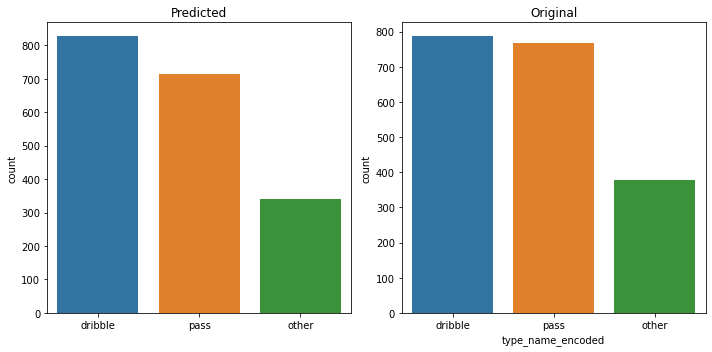

In [130]:
plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
sns.countplot(predictions)
plt.title('Predicted')
plt.subplot(1,2,2)
sns.countplot(modeling_train_df[modeling_train_df['player_id']==15579]['type_name_encoded'].dropna())
plt.title('Original')
plt.tight_layout()
plt.show()

In [131]:
prediction_matrix = modeling_train_df[modeling_train_df['player_id']==15579].dropna()[['type_name_encoded']]

# prediction_matrix.rename(columns={0:'Prediction'}, inplace=True)

In [132]:
prediction_matrix['prediction'] = predictions

In [133]:
prediction_matrix['hit'] = [1 if x['type_name_encoded'] == x['prediction'] else 0 for i,x in prediction_matrix.iterrows()]

In [134]:
prediction_matrix['hit'].mean()

0.7852206273258905

## VAEP Approach

```Create new column transform for this use case ```

In [179]:
numeric_features_vaep = [
    'start_x',
    'start_y',
    'end_x',
    'end_y',
    'x_dif',
    'y_dif',
    'time_seconds',
    'n-1_x_distance',
    'n-1_y_distance',
    'n-1_start_x',
    'n-1_start_y',
    'n-1_end_x',
    'n-1_end_y',
    'n-2_x_distance',
    'n-2_y_distance',
    'n-2_start_x',
    'n-2_start_y',
    'n-2_end_x',
    'n-2_end_y',
    'n-3_x_distance',
    'n-3_y_distance',
    'n-3_start_x',
    'n-3_start_y',
    'n-3_end_x',
    'n-3_end_y',
    'n-4_x_distance',
    'n-4_y_distance',
    'n-4_start_x',
    'n-4_start_y',
    'n-4_end_x',
    'n-4_end_y',
    'n-5_x_distance',
    'n-5_y_distance',
    'n-5_start_x',
    'n-5_start_y',
    'n-5_end_x',
    'n-5_end_y',
    ]

categorical_features_vaep = [
    'period_id',
    'start_pitch_zone',
    'end_pitch_zone',
    'opponent_id',
    'home',
    'type_name',
    'result_name',
    'bodypart_name',
    'n-1_same_team',
    'n-1_x_fwd_direction',
    'n-1_y_lft_right_direction',
    'n-1_start_pitch_zone',
    'n-1_end_pitch_zone',
    'n-1_result_name',
    'n-1_bodypart_name',
    'n-2_same_team',
    'n-2_x_fwd_direction',
    'n-2_y_lft_right_direction',
    'n-2_start_pitch_zone',
    'n-2_end_pitch_zone',
    'n-2_result_name',
    'n-2_bodypart_name',
    'n-3_same_team',
    'n-3_x_fwd_direction',
    'n-3_y_lft_right_direction',
    'n-3_start_pitch_zone',
    'n-3_end_pitch_zone',
    'n-3_result_name',
    'n-3_bodypart_name',
    'n-4_same_team',
    'n-4_x_fwd_direction',
    'n-4_y_lft_right_direction',
    'n-4_start_pitch_zone',
    'n-4_end_pitch_zone',
    'n-4_result_name',
    'n-4_bodypart_name',
    'n-5_same_team',
    'n-5_x_fwd_direction',
    'n-5_y_lft_right_direction',
    'n-5_start_pitch_zone',
    'n-5_end_pitch_zone',
    'n-5_result_name',
    'n-5_bodypart_name',
    'n-1_same_player',
    'n-2_same_player',
    'n-3_same_player',
    'n-4_same_player',
    'n-5_same_player',
    ]

# some of the features below will need dropping before training the model - but are required here for filtering dataset
# passthrough_features = [
#     'vaep_value'
#     ]

drop_features_vaep = [
    'original_event_id',
    'game_id',
    'player_id',
    'team_id',
    'type_id',
    'result_id',
    'bodypart_id',
    'action_id',
    'type_name_encoded',
    'n-5_type_name_encoded',
    'n-4_type_name_encoded',
    'n-3_type_name_encoded',
    'n-2_type_name_encoded',
    'n-1_type_name_encoded',
    'offensive_value',
    'defensive_value',
    'n-5_offensive_value',
    'n-5_defensive_value',
    'n-5_vaep_value',
    'n-4_offensive_value',
    'n-4_defensive_value',
    'n-4_vaep_value',
    'n-3_offensive_value',
    'n-3_defensive_value',
    'n-3_vaep_value',
    'n-2_offensive_value',
    'n-2_defensive_value',
    'n-2_vaep_value',
    'n-1_offensive_value',
    'n-1_defensive_value',
    'n-1_vaep_value'
    ]

In [136]:
ct_vaep = make_column_transformer(
    (StandardScaler(), numeric_features_vaep),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features_vaep),
    ('drop', drop_features_vaep))

In [143]:
team_train_set = modeling_train_df[modeling_train_df['team_id']==965].dropna()
team_test_set = modeling_test_df[(modeling_test_df['team_id']==965)&(modeling_test_df['player_id']==15579)].dropna()
# team_test_set = modeling_test_df[modeling_test_df['team_id']==973].dropna()

X_train = team_train_set.drop(columns=['vaep_value'])
y_train_vaep = team_train_set['vaep_value']


X_test = team_test_set.drop(columns=['vaep_value'])
y_test_vaep = team_test_set['vaep_value']


In [152]:
transformed_train_df = ct_vaep.fit_transform(X_train)
column_names = (
    numeric_features_vaep
    # + passthrough_features
    + ct_vaep.named_transformers_['onehotencoder'].get_feature_names_out().tolist())
    
transformed_train_df = pd.DataFrame(transformed_train_df, columns=column_names)
transformed_train_df.head(20)

,start_x,start_y,end_x,end_y,x_dif,y_dif,time_seconds,n-1_x_distance,n-1_y_distance,n-1_start_x,n-1_start_y,n-1_end_x,n-1_end_y,n-2_x_distance,n-2_y_distance,n-2_start_x,n-2_start_y,n-2_end_x,n-2_end_y,n-3_x_distance,n-3_y_distance,n-3_start_x,n-3_start_y,n-3_end_x,n-3_end_y,n-4_x_distance,n-4_y_distance,n-4_start_x,n-4_start_y,n-4_end_x,n-4_end_y,n-5_x_distance,n-5_y_distance,n-5_start_x,n-5_start_y,n-5_end_x,n-5_end_y,period_id_1,period_id_2,start_pitch_zone_zone_1,start_pitch_zone_zone_2,start_pitch_zone_zone_3,start_pitch_zone_zone_4,start_pitch_zone_zone_5,start_pitch_zone_zone_6,start_pitch_zone_zone_7,start_pitch_zone_zone_8,start_pitch_zone_zone_9,end_pitch_zone_zone_1,end_pitch_zone_zone_2,end_pitch_zone_zone_3,end_pitch_zone_zone_4,end_pitch_zone_zone_5,end_pitch_zone_zone_6,end_pitch_zone_zone_7,end_pitch_zone_zone_8,end_pitch_zone_zone_9,opponent_id_746,opponent_id_749,opponent_id_966,opponent_id_967,opponent_id_968,opponent_id_969,opponent_id_970,opponent_id_971,opponent_id_972,opponent_id_973,opponent_id_974,opponent_id_1475,home_0,home_1,type_name_bad_touch,type_name_clearance,type_name_corner_crossed,type_name_corner_short,type_name_cross,type_name_dribble,type_name_foul,type_name_freekick_crossed,type_name_freekick_short,type_name_goalkick,type_name_interception,type_name_keeper_claim,type_name_keeper_punch,type_name_keeper_save,type_name_pass,type_name_shot,type_name_shot_freekick,type_name_shot_penalty,type_name_tackle,type_name_take_on,type_name_throw_in,result_name_fail,result_name_offside,result_name_owngoal,result_name_success,result_name_yellow_card,bodypart_name_foot,bodypart_name_head,bodypart_name_other,n-1_same_team_False,n-1_same_team_True,n-1_x_fwd_direction_0,n-1_x_fwd_direction_1,n-1_y_lft_right_direction_0,n-1_y_lft_right_direction_1,n-1_start_pitch_zone_zone_1,n-1_start_pitch_zone_zone_2,n-1_start_pitch_zone_zone_3,n-1_start_pitch_zone_zone_4,n-1_start_pitch_zone_zone_5,n-1_start_pitch_zone_zone_6,n-1_start_pitch_zone_zone_7,n-1_start_pitch_zone_zone_8,n-1_start_pitch_zone_zone_9,n-1_end_pitch_zone_zone_1,n-1_end_pitch_zone_zone_2,n-1_end_pitch_zone_zone_3,n-1_end_pitch_zone_zone_4,n-1_end_pitch_zone_zone_5,n-1_end_pitch_zone_zone_6,n-1_end_pitch_zone_zone_7,n-1_end_pitch_zone_zone_8,n-1_end_pitch_zone_zone_9,n-1_result_name_fail,n-1_result_name_offside,n-1_result_name_owngoal,n-1_result_name_success,n-1_result_name_yellow_card,n-1_bodypart_name_foot,n-1_bodypart_name_head,n-1_bodypart_name_other,n-2_same_team_False,n-2_same_team_True,n-2_x_fwd_direction_0,n-2_x_fwd_direction_1,n-2_y_lft_right_direction_0,n-2_y_lft_right_direction_1,n-2_start_pitch_zone_zone_1,n-2_start_pitch_zone_zone_2,n-2_start_pitch_zone_zone_3,n-2_start_pitch_zone_zone_4,n-2_start_pitch_zone_zone_5,n-2_start_pitch_zone_zone_6,n-2_start_pitch_zone_zone_7,n-2_start_pitch_zone_zone_8,n-2_start_pitch_zone_zone_9,n-2_end_pitch_zone_zone_1,n-2_end_pitch_zone_zone_2,n-2_end_pitch_zone_zone_3,n-2_end_pitch_zone_zone_4,n-2_end_pitch_zone_zone_5,n-2_end_pitch_zone_zone_6,n-2_end_pitch_zone_zone_7,n-2_end_pitch_zone_zone_8,n-2_end_pitch_zone_zone_9,n-2_result_name_fail,n-2_result_name_offside,n-2_result_name_owngoal,n-2_result_name_success,n-2_result_name_yellow_card,n-2_bodypart_name_foot,n-2_bodypart_name_head,n-2_bodypart_name_other,n-3_same_team_False,n-3_same_team_True,n-3_x_fwd_direction_0,n-3_x_fwd_direction_1,n-3_y_lft_right_direction_0,n-3_y_lft_right_direction_1,n-3_start_pitch_zone_zone_1,n-3_start_pitch_zone_zone_2,n-3_start_pitch_zone_zone_3,n-3_start_pitch_zone_zone_4,n-3_start_pitch_zone_zone_5,n-3_start_pitch_zone_zone_6,n-3_start_pitch_zone_zone_7,n-3_start_pitch_zone_zone_8,n-3_start_pitch_zone_zone_9,n-3_end_pitch_zone_zone_1,n-3_end_pitch_zone_zone_2,n-3_end_pitch_zone_zone_3,n-3_end_pitch_zone_zone_4,n-3_end_pitch_zone_zone_5,n-3_end_pitch_zone_zone_6,n-3_end_pitch_zone_zone_7,n-3_end_pitch_zone_zone_8,n-3_end_pitch_zone_zone_9,n-3_result_name_fail,n-3_result_name_offside,n-3_result_name_owngoal,n-3_result_name_

In [146]:
pipe = make_pipeline(ct_vaep, LinearRegression())
pipe.fit(X_train, y_train_vaep)
print(pipe.score(X_train, y_train_vaep))
print(pipe.score(X_test, y_test_vaep))

0.09864420108992877
-2.2249490466373796e+20


In [148]:
pipe = make_pipeline(ct_vaep, DecisionTreeRegressor())
pipe.fit(X_train, y_train_vaep)
print(pipe.score(X_train, y_train_vaep))
print(pipe.score(X_test, y_test_vaep))

1.0
0.5574114812278153


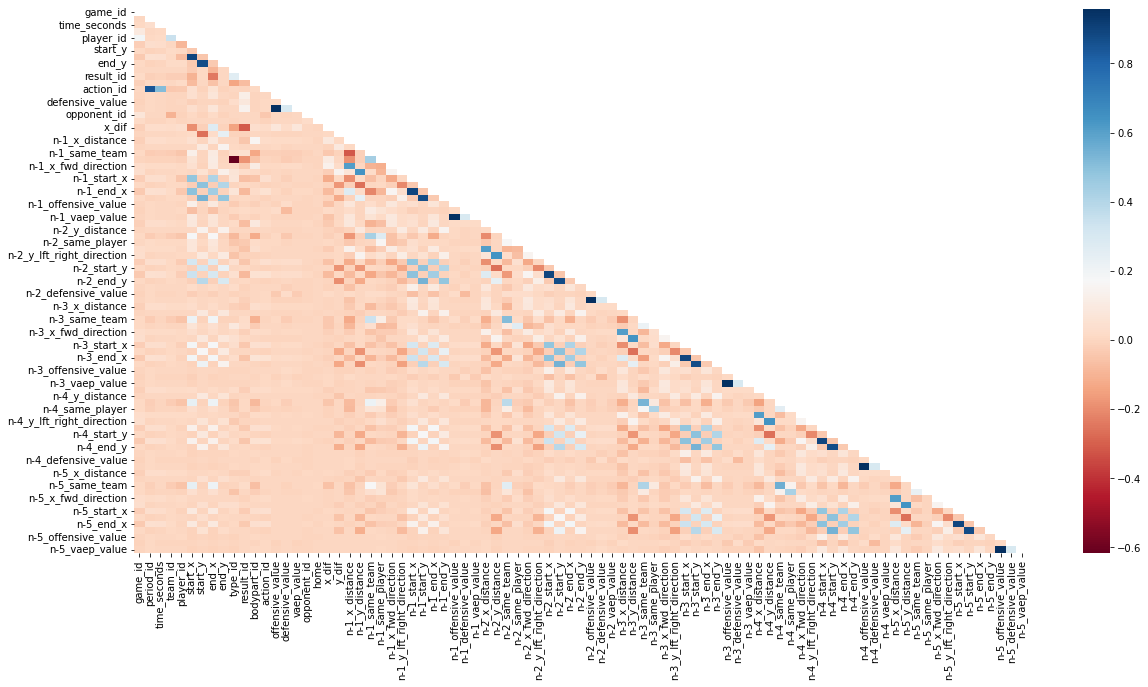

In [153]:
# find the correlation between the variables
corr = modeling_train_df.corr()

# plot the correlation matrix using a heatmap
plt.figure(figsize=(20,10))
matrix = np.triu(corr)
sns.heatmap(corr, mask=matrix, cmap='RdBu')
plt.show()

In [154]:
from scipy import stats
data = []
num_col = transformed_train_df.dropna().select_dtypes(include=[np.number])

for column in num_col.corr().columns:
    data.append(stats.pearsonr(y_train_vaep, num_col[column]))

end_zone_corr = pd.DataFrame(data, index=num_col.corr().columns, columns=['Correlation', 'P_value'])

end_zone_corr.style.background_gradient(cmap='Oranges')

,Correlation,P_value
start_x,0.013827,0.021306
start_y,0.007100,0.237114
end_x,0.048144,0.000000
end_y,-0.000512,0.932120
x_dif,0.072718,0.000000
y_dif,-0.015647,0.009170
time_seconds,0.009886,0.099712
n-1_x_distance,0.017455,0.003651
n-1_y_distance,0.003783,0.528780
n-1_start_x,-0.009567,0.111132


In [155]:
end_zone_corr[end_zone_corr['P_value']< 0.005].style.background_gradient(cmap='Oranges')

,Correlation,P_value
end_x,0.048144,0.000000
x_dif,0.072718,0.000000
n-1_x_distance,0.017455,0.003651
n-2_start_x,0.021532,0.000336
n-2_end_x,0.020958,0.000482
n-4_y_distance,-0.025001,0.000031
start_pitch_zone_zone_8,0.020202,0.000767
end_pitch_zone_zone_8,0.075261,0.000000
type_name_bad_touch,-0.067611,0.000000
type_name_corner_crossed,0.022405,0.000191


To do: 
- Pearson correlation between target and model variables
- Find an alternative to dropping nas

## Modeling 

**Approach to modeling:**

1. Pick a player to replace in a team
2. Get the top players in their cluster as potential replacements 
3. Fit a model for each of the scouted players 
    - use only that player's data to fit the model
    - the models will predict their next location and the action they take 
    - the parameters in the model should cover the player characteristics and team characteristics. For example, the 5 past moves cover what the team does, and how then the player reacts to those. The player action is the predicted target 

**Model validation and testing approach:**

- Of the scouted players, find those that have undergone a transfer in season 3 in our data set - use season 3 data to test our predictions. 
- Score the model based on the real data from their new team


**Models to train and test:**

- Baseline model for logistic regression for next action and end pitch location
- Random Forest classifier for end pitch location and next action 
- xGBoost classifier for end pitch location and next action 
- Random Forest regressor for end_x and end_y location 
- xGBoost regressor for enx_x and end_y location